We wish to efficiently perform comparisons in order to approximate a division of the samples into those above and below 50th percentile along some comparative hypothesis. We conduct a Monte-Carlo simulation of a strategy in which we pair together samples in *rounds* and compare them. Crucially, in each "round," we only compare samples with the same "record" thus far (e.g. WLWW). This simulation suggests that for reasonable confidence thresholds such as .90, even "WW" can be confidently classified as in the upper half of the samples. The collection of records that 

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest
from collections import Counter
import json
import random

In [100]:
# generate samples
EXPO = 23
total_samples = np.power(2, EXPO)
samples = np.random.uniform(size=total_samples)

problems (from Ruiqi):
- check if estimator biased - i.e. have ground truth ranking, we wish to recover ranking; bias refers to average deviation from rakning to ground truth, asymptotic
- four quadrants, compare to baseline with MAX_DEPTH rounds, pair & compare

In [164]:
def noisy_greater_than(x, y):
    if random.random() < 0.2:
        return True
    if x > y:
        return True
    return False

In [163]:
def split(samples):
    """Splits the samples into the top and bottom halves."""
    np.random.shuffle(samples) # shuffle samples
    samples_a, samples_b = samples[0::2], samples[1::2]

    top, bottom = [], []
    for a, b in zip_longest(samples_a, samples_b):
        if not b: # in case odd
            b = np.random.choice(samples_b) # pick random sample
            top.append(a) if noisy_greater_than(a, b) else bottom.append(a)
        if noisy_greater_than(a, b): # feed into model, compare logits of snippet A versus snippet B
            top.append(a), bottom.append(b)
        else:
            top.append(b), bottom.append(a)
    return np.array(bottom), np.array(top)

In [165]:
dists = dict()
dists[0] = {'':samples}

def prop_top(dist):
    return sum(dist > 0.5)/len(dist)

In [166]:
CONFIDENCE = .80
safe_prefixes = dict()

num_comparisons = Counter()
num_classified = Counter()

top = np.array([])
bottom = np.array([])

MAX_DEPTH = 18 # EXPO - 1

for i in range(1, MAX_DEPTH + 1): # about 250k
    print(i)
    dists[i] = {}
    for record, dist_to_split in dists[i-1].items():
        prop = prop_top(dist_to_split)
        if max(prop, 1-prop) > CONFIDENCE:
            num_classified[i-1] += len(dist_to_split)
            safe_prefixes[record] = prop
            if prop > 0.5: top = np.append(top, dist_to_split, 0)
            else: bottom = np.append(bottom, dist_to_split, 0)
            continue
        if i == MAX_DEPTH:
            num_classified[i-1] += len(dist_to_split)
            wins = sum(int(x) for x in record)
            if wins / len(record) >= 0.5: top = np.append(top, dist_to_split, 0)
            else: bottom = np.append(bottom, dist_to_split, 0)
            continue

        num_comparisons[i] += len(dist_to_split)
        lesser, greater = split(dist_to_split)
        dists[i][record + '0'] = lesser
        dists[i][record + '1'] = greater

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [104]:
with open('../prefixes/prefixes_95.json', 'w') as f:
    json.dump(safe_prefixes, f)

Text(0.5, 0, 'Round')

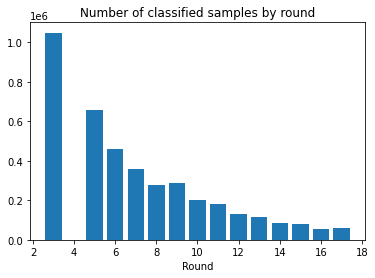

In [109]:
plt.bar(*zip(*sorted(num_classified.items())))
plt.title('Number of classified samples by round')
plt.xlabel('Round')

Text(0.5, 0, 'Round')

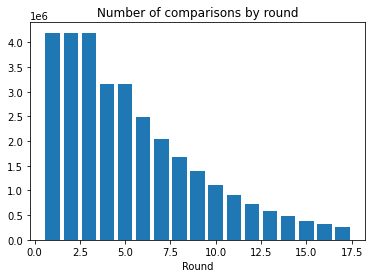

In [110]:
plt.bar(*zip(*sorted(num_comparisons.items())))
plt.title('Number of comparisons by round')
plt.xlabel('Round')

In [167]:
sum([x*y for x, y in num_classified.items()])/total_samples

3.9515533447265625

In [168]:
(sum(top > 0.5) + sum(bottom < 0.5))/total_samples

0.8653926849365234

## Baseline Approach

In [149]:
num_baseline_samples = 1000000
baseline_samples = np.random.uniform(size=num_baseline_samples)
wins = np.array([0] * num_baseline_samples)

In [150]:
def run_round():
    """Splits the samples into the top and bottom halves."""
    indices = np.arange(0, num_baseline_samples)
    np.random.shuffle(indices) # shuffle samples
    indices_A, indices_B = indices[1::2], indices[::2]

    top, bottom = [], []
    for index_A, index_B in zip_longest(indices_A, indices_B):
        a = baseline_samples[index_A]
        b = baseline_samples[index_B]
        if not b: # in case odd
            b = np.random.choice(baseline_samples) # pick random sample
            if a > b: wins[index_A] += 1
        if a < b: # feed into model, compare logits of snippet A versus snippet B
            wins[index_B] += 1
        else:
            wins[index_A] += 1
    return np.array(bottom), np.array(top)

In [151]:
NUM_ROUNDS = 15
for _ in range(NUM_ROUNDS):
    run_round()

In [152]:
baseline_top = baseline_samples[wins > NUM_ROUNDS // 2]
baseline_bottom = baseline_samples[wins <= NUM_ROUNDS // 2]

In [153]:
accuracy = (sum(baseline_top > 0.5) + sum(baseline_bottom < 0.5))/num_baseline_samples
accuracy

0.901684

### Baseline Approach with Pruning